In [1]:
import os

import pandas as pd
import numpy as np

import torch

torch.set_default_dtype(torch.double)

import torch.nn.functional as F
import gpytorch
import botorch

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
plt.style.use("seaborn-v0_8-paper")

# params = {
#     "figure.figsize": (8, 6),
#     # "text.usetex": True,
#     # "font.family": "serif",
#     # "font.family": "Times New Roman",
#     "axes.labelsize": 12,
#     "font.size": 12,
#     "legend.fontsize": 15,
# }

# plt.rcParams.update(params)

# generate embedding

In [2]:
test_path = "../data/DB_10042.csv"
train_path = "../data/Label1000.csv"

In [3]:
test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]
train_df = pd.read_csv(train_path, index_col=0)

/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_38610/1857343925.py:1: DtypeWarning: Columns (2,3,4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]
/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_38610/1857343925.py:2: DtypeWarning: Columns (15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path, index_col=0)


In [5]:
fixed_covariance_matrix_path = "../data/DB_10042_fixed_covariance_matrix.npy"
fixed_covariance_matrix = np.load(fixed_covariance_matrix_path)

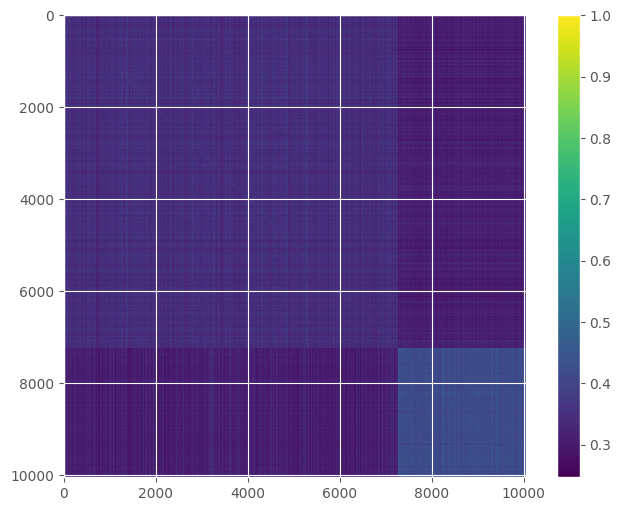

In [6]:
plt.imshow(fixed_covariance_matrix)
plt.colorbar()
plt.show()

In [7]:
from sklearn.manifold import MDS

In [9]:
mds = MDS(random_state=0, dissimilarity="precomputed")
embedding = mds.fit_transform(1 - fixed_covariance_matrix)
embedding.shape

/Users/quannguyen/anaconda3/envs/mof_search/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(10042, 2)

In [12]:
np.save("../data/fixed_covariance_matrix_embedding.npy", embedding)

# show embedding

In [3]:
embedding = np.load("../data/fixed_covariance_matrix_embedding.npy")
embedding.shape

(10042, 2)

In [4]:
threshold = 7239
core_mask = np.arange(embedding.shape[0]) < threshold

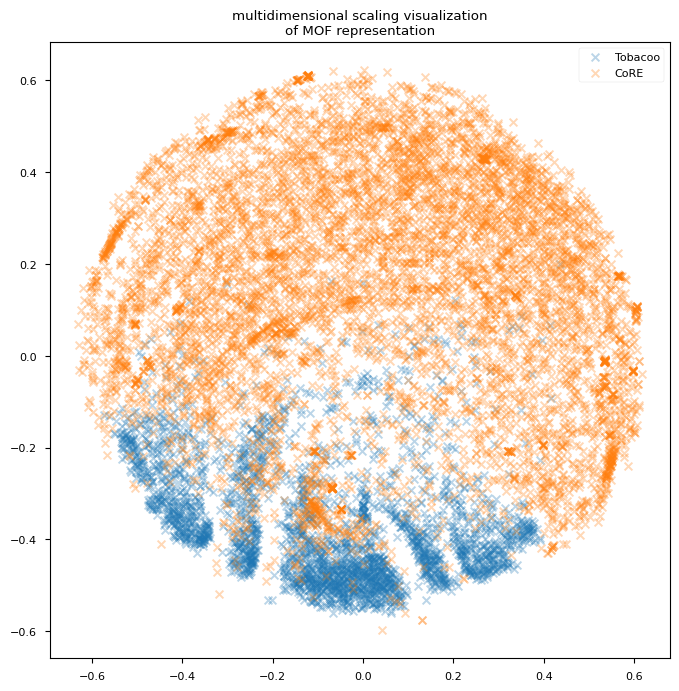

In [5]:
plt.figure(figsize=(8, 8))

plt.scatter(
    embedding[~core_mask, 0],
    embedding[~core_mask, 1],
    marker="x",
    alpha=0.3,
    label="Tobacoo",
)

plt.scatter(
    embedding[core_mask, 0],
    embedding[core_mask, 1],
    marker="x",
    alpha=0.3,
    label="CoRE",
)

plt.legend()

plt.title("multidimensional scaling visualization\nof MOF representation")

plt.show()

In [5]:
test_path = "../data/DB_10042.csv"
train_path = "../data/Label1000_extended.csv"

In [6]:
test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]
train_df = pd.read_csv(train_path, index_col=0)#.iloc[:, ]

/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_25627/2574958251.py:1: DtypeWarning: Columns (2,3,4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]


In [7]:
test_uid = list(test_df.index)
train_uid = list(train_df.index)

train_ind = []

for ind in train_uid:
    if ind in test_uid:
        train_ind.append(test_uid.index(ind))
    else:
        train_df = train_df.drop(index=ind)
        
len(train_ind), train_df.shape

(998, (998, 1045))

In [8]:
train_ind = torch.tensor(train_ind, dtype=torch.long)

# target = "M_Storage"
# target = "M_DBD"
target = "M_safety"

train_y = torch.tensor(train_df[target].values)

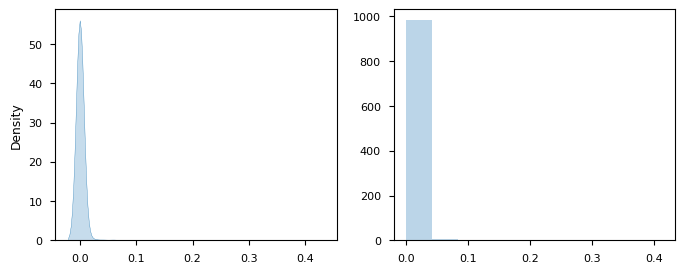

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

sns.kdeplot(train_y, fill=True, ax=ax[0])
ax[1].hist(train_y, alpha=0.3)

plt.show()

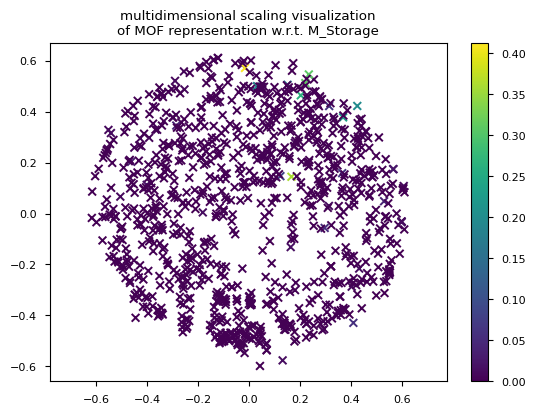

In [11]:
plt.scatter(
    embedding[train_ind, 0],
    embedding[train_ind, 1],
    marker="x",
    c=train_y,
)
plt.axis("equal")
plt.colorbar()

plt.title("multidimensional scaling visualization\nof MOF representation w.r.t. M_Storage")

plt.show()

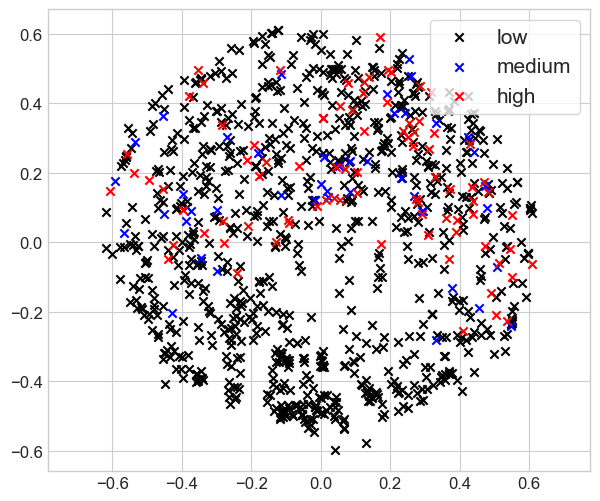

In [17]:
# labels = ["low", "medium", "high"]
# labels = ["M_Storage < 5", "5 < M_Storage < 15", "M_Storage > 15"]
# labels = []

label_to_color = {labels[0]: "k", labels[1]: "b", labels[2]: "r"}

classification_labels = []

for value in train_y:
    # if value < 5:
    if value < 1000:
        label = labels[0]
    # elif value < 15:
    elif value < 3000:
        label = labels[1]
    else:
        label = labels[2]
    
    classification_labels.append(label)

classification_labels = np.array(classification_labels)
        
# plt.scatter(
#     embedding[train_ind, 0],
#     embedding[train_ind, 1],
#     marker="x",
#     c=classification_labels,
# )

plt.figure(figsize=(7, 6))

for label in labels:
    mask = classification_labels == label
    
    plt.scatter(
        embedding[train_ind[mask], 0],
        embedding[train_ind[mask], 1],
        marker="x",
        c=label_to_color[label],
        label=label,
    )

plt.axis("equal")
# plt.colorbar()
plt.legend(frameon=True)

# plt.title("multidimensional scaling visualization\nof MOF representation w.r.t. M_Storage")

plt.show()

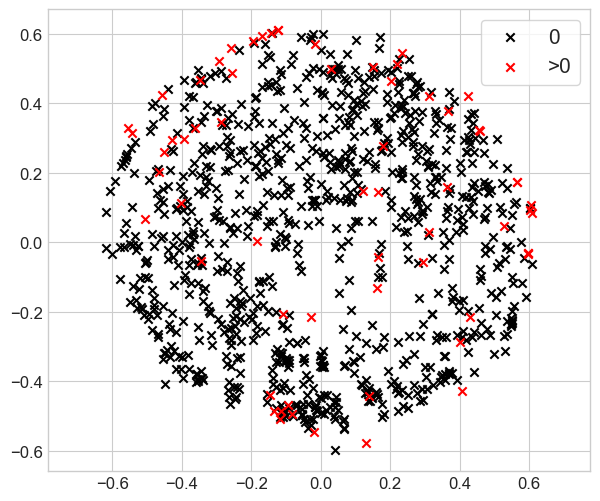

In [33]:
labels = ["0", ">0"]

label_to_color = {labels[0]: "k", labels[1]: "r"}

classification_labels = []

for value in train_y:
    if value == 0:
        label = labels[0]
    else:
        label = labels[1]
    
    classification_labels.append(label)

classification_labels = np.array(classification_labels)
        
# plt.scatter(
#     embedding[train_ind, 0],
#     embedding[train_ind, 1],
#     marker="x",
#     c=classification_labels,
# )

plt.figure(figsize=(7, 6))

for label in labels:
    mask = classification_labels == label
    
    plt.scatter(
        embedding[train_ind[mask], 0],
        embedding[train_ind[mask], 1],
        marker="x",
        c=label_to_color[label],
        label=label,
    )

plt.axis("equal")
# plt.colorbar()
plt.legend(frameon=True)

# plt.title("multidimensional scaling visualization\nof MOF representation w.r.t. M_Storage")

plt.show()

In [9]:
def get_classification_labels(train_y, thresholds, labels):
    classification_labels = []

    for value in train_y:
        if value < thresholds[0]:
            label = labels[0]
        elif value < thresholds[1]:
            label = labels[1]
        else:
            label = labels[2]

        classification_labels.append(label)

    return np.array(classification_labels)

In [10]:
params = {
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    # "title.fontsize": 12,
}

plt.rcParams.update(params)

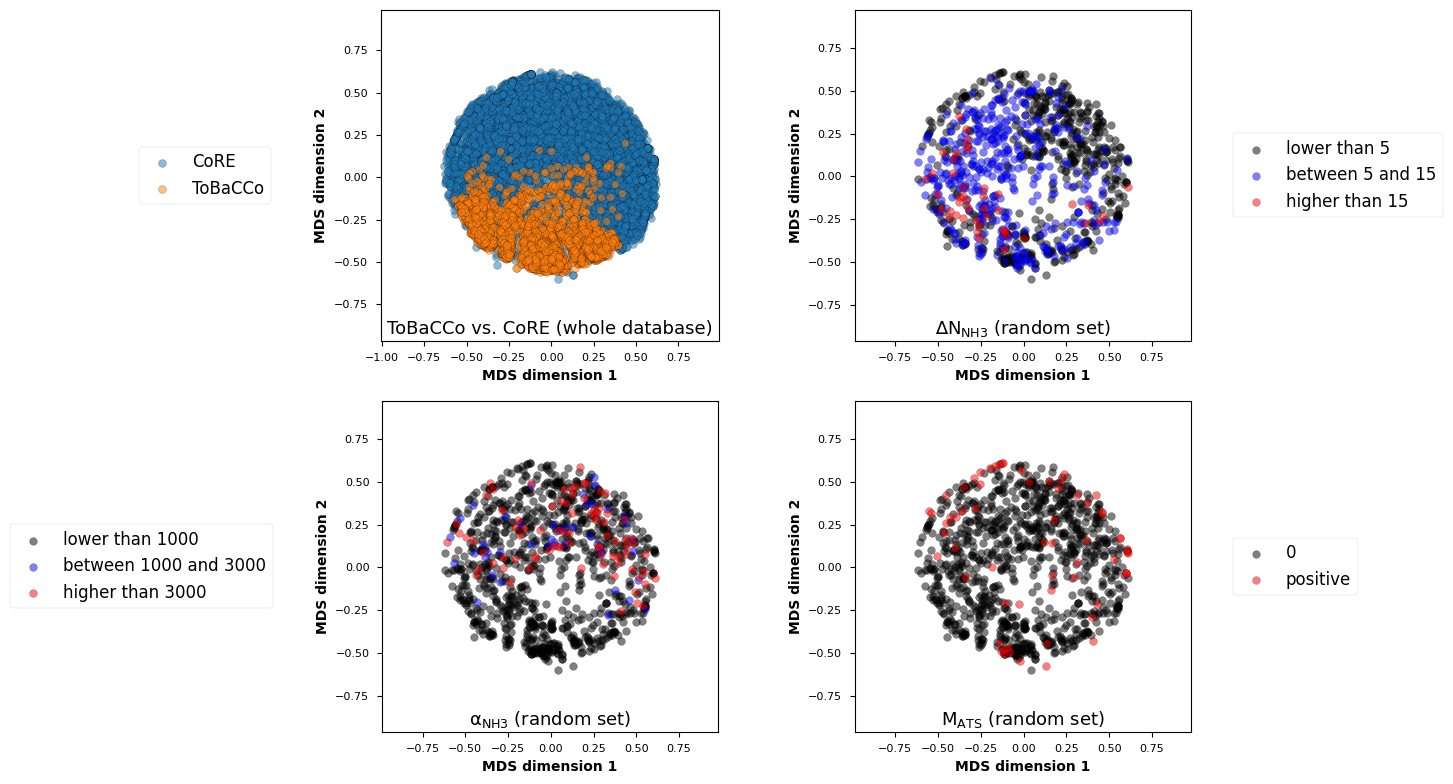

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

ax[0][0].scatter(
    embedding[core_mask, 0],
    embedding[core_mask, 1],
    # marker="x",
    alpha=0.5,
    edgecolor="k",
    label="CoRE",
)

ax[0][0].scatter(
    embedding[~core_mask, 0],
    embedding[~core_mask, 1],
    # marker="x",
    alpha=0.5,
    edgecolor="k",
    label="ToBaCCo",
)

legend = ax[0][0].legend(frameon=True, bbox_to_anchor=(-0.3, 0.5), loc="center right")
legend.get_frame().set_alpha(None)
ax[0][0].set_title("ToBaCCo vs. CoRE (whole database)", fontsize=13, y=0, pad=5)
ax[0][0].margins(0.3, 0.3)

labels = ["lower than 5", "between 5 and 15", "higher than 15"]
label_to_color = {labels[0]: "k", labels[1]: "b", labels[2]: "r"}
classification_labels = get_classification_labels(
    torch.tensor(train_df["M_Storage"].values), [5, 15], labels
)

for label in labels:
    mask = classification_labels == label
    
    ax[0][1].scatter(
        embedding[train_ind[mask], 0],
        embedding[train_ind[mask], 1],
        # marker="x",
        alpha=0.5,
        c=label_to_color[label],
        label=label,
        edgecolor="k",
    )

legend = ax[0][1].legend(frameon=True, bbox_to_anchor=(1.1, 0.5), loc="center left")
legend.get_frame().set_alpha(None)
ax[0][1].set_title(r"${\rm ∆N}_{\rm NH3}$" + " (random set)", fontsize=13, y=0, pad=5)
ax[0][1].margins(0.3, 0.3)

labels = ["lower than 1000", "between 1000 and 3000", "higher than 3000"]
label_to_color = {labels[0]: "k", labels[1]: "b", labels[2]: "r"}
classification_labels = get_classification_labels(
    torch.tensor(train_df["M_DBD"].values), [1000, 3000], labels
)

for label in labels:
    mask = classification_labels == label
    
    ax[1][0].scatter(
        embedding[train_ind[mask], 0],
        embedding[train_ind[mask], 1],
        # marker="x",
        alpha=0.5,
        c=label_to_color[label],
        label=label,
        edgecolor="k",
    )

legend = ax[1][0].legend(frameon=True, bbox_to_anchor=(-0.3, 0.5), loc="center right")
legend.get_frame().set_alpha(None)
ax[1][0].set_title(r"${\rm \alpha}_{\rm NH3}$" + " (random set)", fontsize=13, y=0, pad=5)
ax[1][0].margins(0.3, 0.3)

labels = ["0", "positive"]
label_to_color = {labels[0]: "k", labels[1]: "r"}
classification_labels = get_classification_labels(
    torch.tensor(train_df["M_safety"].values), [1e-4, float("inf")], labels
)

for label in labels:
    mask = classification_labels == label
    
    ax[1][1].scatter(
        embedding[train_ind[mask], 0],
        embedding[train_ind[mask], 1],
        # marker="x",
        alpha=0.5,
        c=label_to_color[label],
        label=label,
        edgecolor="k",
    )

legend = ax[1][1].legend(frameon=True, bbox_to_anchor=(1.1, 0.5), loc="center left")
legend.get_frame().set_alpha(None)
ax[1][1].set_title(r"${\rm M}_{\rm ATS}$" + " (random set)", fontsize=13, y=0, pad=5)
ax[1][1].margins(0.3, 0.3)

ax[0][0].set_aspect("equal")
ax[0][1].set_aspect("equal")
ax[1][0].set_aspect("equal")
ax[1][1].set_aspect("equal")

ax[0][0].set_xlabel("MDS dimension 1", fontsize=10, fontweight="bold")
ax[0][0].set_ylabel("MDS dimension 2", fontsize=10, fontweight="bold")
ax[0][1].set_xlabel("MDS dimension 1", fontsize=10, fontweight="bold")
ax[0][1].set_ylabel("MDS dimension 2", fontsize=10, fontweight="bold")
ax[1][0].set_xlabel("MDS dimension 1", fontsize=10, fontweight="bold")
ax[1][0].set_ylabel("MDS dimension 2", fontsize=10, fontweight="bold")
ax[1][1].set_xlabel("MDS dimension 1", fontsize=10, fontweight="bold")
ax[1][1].set_ylabel("MDS dimension 2", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()